In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment").to('cuda')

In [7]:
text = "love"
encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to('cuda')
output = model(**encoded_input)
sentiment_label = tokenizer.decode(output['logits'].argmax(-1))
sentiment_score = output['logits'].softmax(-1)
print(f"Text: {text}")
print(f"Predicted Sentiment: {sentiment_label}")
print(f"Sentiment Scores: {sentiment_score}")


Text: love
Predicted Sentiment: [unused4]
Sentiment Scores: tensor([[0.0230, 0.0217, 0.0727, 0.2231, 0.6595]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [73]:
import os
import json
import pandas as pd


# names = pd.Series()

def SaveDataCsv(directory):
    years = pd.Series(dtype='string')
    names = pd.Series(dtype='string')
    ratings = pd.Series(dtype='float')
    reviewlen = pd.Series(dtype='int')
    ratingcounts = pd.Series(dtype='int')
    
    for i in range(1,251):
        with open(f'{directory}/Rank_{i}.json', 'r') as file:
            file_data = file.read()
            data = json.loads(file_data)
            name = data.get("name")
            year = data.get("year")
            rating = data.get("rating")
            reviews = data.get("reviews")
            ratingcount = data.get("rating count")
            names = pd.concat([names,pd.Series(name,dtype='string')],ignore_index=True)
            years = pd.concat([years,pd.Series(year,dtype='string')],ignore_index=True)
            ratings = pd.concat([ratings,pd.Series(rating,dtype='float')],ignore_index=True)
            reviewlen = pd.concat([reviewlen,pd.Series(len(reviews),dtype='int')],ignore_index=True)
            ratingcounts = pd.concat([ratingcounts,pd.Series(ratingcount,dtype='int')],ignore_index=True)
            PdData = pd.DataFrame({'Name':names,'Year':years,'Rating':ratings, 'Review Length':reviewlen, 'Rating Count':ratingcounts})

    PdData.to_csv('data.csv',index=False)


# Usage
directory_path = 'data'
SaveDataCsv(directory_path)


In [4]:
import json

def AddSentimentScore(directory):
    for i in range(51,251):
        with open(f'/content/drive/MyDrive/CovieV2/data/Rank_{i}.json', 'r') as file:

            file_data = file.read()
            data = json.loads(file_data)
            reviews = data.get("reviews")
            print(f"start update /content/drive/MyDrive/CovieV2/data/Rank_{i}.json")
            for q in range(len(reviews)):
                content = reviews[q].get("content")
                encoded_input = tokenizer(content, padding=True, truncation=True, return_tensors='pt').to('cuda')
                output = model(**encoded_input)
                sentiment_score = output['logits'].softmax(-1)
                output_tenser = [round(sentiment_score[0][k].item(),4) for k in range(5)]
                print(len(reviews)-q, end = ' ')
                data["reviews"][q]["sentiment score"] = output_tenser
             
            with open(f'/content/drive/MyDrive/CovieV2/data/Rank_{i}.json', 'w') as outfile:
                json.dump(data, outfile) 
   
directory_path = 'data'
AddSentimentScore(directory_path)

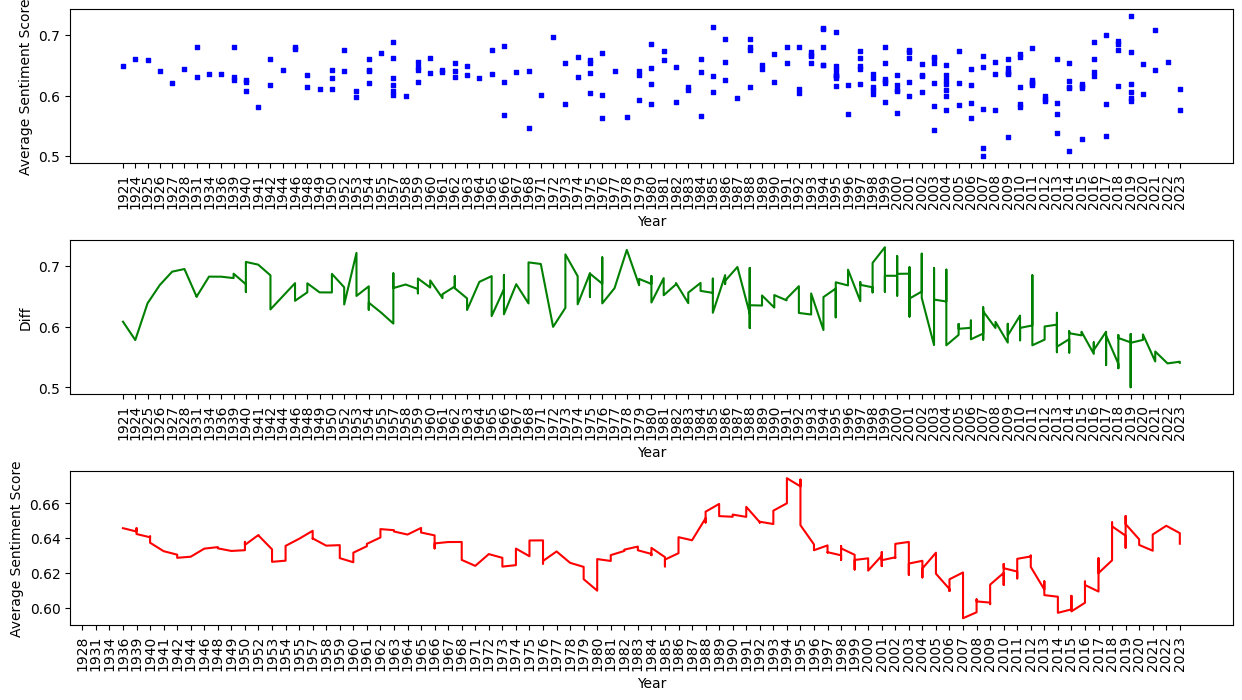

In [16]:
from matplotlib import pyplot as plt
import json
import pandas as pd
import numpy as np
def main():
    dataframe = pd.DataFrame()
    for i in range(1,251):
        with open(f'data/Rank_{i}.json', 'r') as file:
            file_data = file.read()
            data = json.loads(file_data)

            reviews = data.get("reviews")
            year = data.get("year")
            
            each_senti_score = []
            diff_each = []
            for q in range(len(reviews)):
                weight_score = [reviews[q].get("sentiment score")[i]*(i+1)  for  i in range(5)]
                rating = int(reviews[q].get("rating"))
                diff_each.append(abs(sum(weight_score)*2-rating))
                each_senti_score.append(sum(weight_score)*2)

            dataframe = pd.concat([dataframe,pd.DataFrame({'year':year,'average sentiment score':sum(each_senti_score) / len(each_senti_score),'diff':sum(diff_each) / len(diff_each)},index=[0])],ignore_index=True)
    # print(dataframe)
    # normalize data in dataframe
    dataframe['average sentiment score'] = [(i-min(dataframe['average sentiment score']))/(max(dataframe['average sentiment score'])-min(dataframe['average sentiment score'])) for i in dataframe['average sentiment score']]
    dataframe['diff'] = [(i-min(dataframe['diff']))/(max(dataframe['diff'])-min(dataframe['diff'])) for i in dataframe['diff']]

    dataframe = dataframe.sort_values(by='year')
    
    dataframe['average sentiment score'] = [1/(1+np.exp(-i)) for i in dataframe['average sentiment score']]
    dataframe['diff'] = [1/(1+np.exp(-i)) for i in dataframe['diff']]
   

    plt.figure(figsize=(15, 8))

    # subplot 1
    plt.subplot(311)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Average Sentiment Score', fontsize=10)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.scatter(dataframe['year'], dataframe['average sentiment score'], s=10, c='b', marker="s")
    
    plt.subplot(312)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Diff', fontsize=10)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.plot(dataframe['year'], dataframe['diff'], c='g')
    plt.subplot(313)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Average Sentiment Score', fontsize=10)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.plot(dataframe['year'], dataframe['average sentiment score'].rolling(10).mean(), c='r' )
    # make plots not so close
    plt.subplots_adjust(hspace=0.5)
    plt.show()        
main()